### Set up

First ensure you are using the correct Kernel, this ensures you are using the correct Python virtual environment that has Euphonic installed. In the tool bar above click `Kernel` -> `Change kernel` -> `euphonic`

Now ensure you have the correct version of Euphonic installed. Run the following cell, you should get `0.6.0`

In [ ]:
import euphonic
print(euphonic.__version__)

If you don't, you can upgrade your version of Euphonic by opening a terminal and activating the Euphonic virual environment with:
```
source /usr/local/virtualenvs/euphonicenv/bin/activate
```
Then install version 0.6.0 of euphonic with
```
python -mpip install euphonic==0.6.0
```
Once this is done, you will have to restart the Jupyter notebook Kernel by clicking `Kernel` -> `Restart` in the bar above

### Python Help - Viewing documentation and exploring objects

In addition to the Euphonic documentation at https://euphonic.readthedocs.io/en/v0.6.0, there is also various help available directly in Python. Use `dir` to look at the available Euphonic objects and modules. Be careful about using anything that begins with an underscore `_`, these are considered private and could change at any time!

In [ ]:
#import euphonic
#dir(euphonic)

`dir` also works on objects themselves:

In [ ]:
#from euphonic import ForceConstants
#fc = ForceConstants.from_castep('quartz/quartz.castep_bin')
#dir(fc)

You can also use `help` on an object to see its docstring - this will tell you about its attributes and methods

In [ ]:
#help(fc)

Or on a specific method:

In [ ]:
#help(fc.calculate_qpoint_phonon_modes)

### File Access
All data files used in this tutorial can be found in the Git repository at https://github.com/pace-neutrons/edatc/blob/main/euphonic_files, they are also available in `/mnt/ceph/auxilary/excitations/edatc/euphonic_files`

## 1. Plotting Dispersion

**1a)** First we need to read the force constants for Quartz from the `quartz.castep_bin` file - we do this with the `ForceConstants.from_castep` method, which returns a `ForceConstants` object. How do we know this object contains the material we were expecting? Try looking at the help for the `crystal` attribute of the `ForceConstants` object you just created. What attributes of `crystal` can we look at to tell us what material we have read in?

In [ ]:
from euphonic import ForceConstants

fc = ForceConstants.from_castep('../euphonic_files/quartz.castep_bin')
#help(fc.crystal)

As mentioned earlier, polar materials have a longer ranged force-constants matrix, but rather than calculate a larger force constants matrix, it is more efficient to compute a correction to the matrix (although this is still quite expensive!).

This correction requires the Born effective charges and dielectric permitivitty tensor. As Quartz is a polar material, the `ForceConstants` object also contains these quantities.

In [ ]:
fc.born

**1b)** If we want to plot a dispersion, we need to calculate phonon frequencies for the Q-direction we want to plot in. Q-points for the 1, 0, 0 direction have already been calculated in the cell below using `Numpy`. Use the `ForceConstants.calculate_qpoint_frequencies` method to fill in the gap. This produces a new kind of object, a `QpointFrequencies` object, which contains `crystal` information just like before, but also q-points and frequencies. Look at the phonon frequencies for the first q-point: do they seem sensible?

In [ ]:
# This creates an array of q-points in the 1, 0, 0 direction
import numpy as np
n_qpts = 101
qpts = np.zeros((n_qpts, 3))
qpts[:, 0] = np.linspace(0, 1.0, n_qpts)

modes = # Use calculate_qpoint_frequencies here!

modes.frequencies[0]

You may notice the frequencies have both a magnitude and a unit - this is true for all dimensioned data in Euphonic. We can change the units frequencies are displayed in by setting `QpointPhononModes.frequencies_unit`. What other units are commonly used for phonon frequencies?

In [ ]:
modes.frequencies_unit = '1/cm'
modes.frequencies[0]

**1c)** To plot a dispersion we need to get the distance between each q-point to be able to plot it on an axis - this can be done with `QpointFrequencies.get_dispersion`. This returns a `Spectrum1DCollection` object, which is used in Euphonic for storing multiple sets of 1D data on the same axes - this fits the description of a bandstructure! It contains all the x and y-axis data required for a plot. All the plotting tools are contained in the `euphonic.plot` module, `plot_1d` can be used to plot `Spectrum1D` or `Spectrum1DCollection` objects.

In [ ]:
# We need this line so plots display nicely and interactively in the notebook
%matplotlib notebook

from euphonic.plot import plot_1d
dispersion = modes.get_dispersion()
fig = plot_1d(dispersion)

Do you notice anything strange about the acoustic frequencies near the gamma points? This can be fixed by applying the **acoustic sum rule** when calculating the q-point frequencies. Use the help for `ForceConstants.calculate_qpoint_frequencies` to figure out which argument to use to apply the sum rule, and recalculate and replot the frequencies.

The x-axis labels aren't very helpful - these are stored in `Spectrum1DCollection.x_tick_labels`. Try setting them to something else more informative and replotting. Also try using the arguments of `plot_1d` to add more helpful axis titles too.

**Extra** Using the `'realspace'` acoustic sum rule actually appears to make things worse! Why could this be? Hint: Quartz is a polar material

**1d)** Now plot another dispersion, but this time in the 0, 0, 1 direction. It looks a little different and has lots of points where the modes cross each other. We can follow the modes across reciprocal space by reordering them with `QpointPhononModes.reorder_frequencies`. This requires the eigenvectors so this time we'll need to use `ForceConstants.calculate_qpoint_phonon_modes` instead of `ForceConstants.calculate_qpoint_frequencies`. This returns a `QpointPhononModes` object. This is almost the same as `QpointFrequencies` except it also contains the eigenvectors.

**1e)** We have plotted dispersion in 2 Q-directions, but often it is helpful to plot a path through the Brillouin Zone. Another package, `seekpath` has a function to automatically get a recommended Q-path from the crystal information. It needs the crystal information in a specific form, which is output by `Crystal.to_spglib_cell`. `seekpath` has already been used below to generate a q-point path. Now use `Euphonic` to calculate the q-point frequencies and plot the dispersion. Use `splitting=True` and `insert_gamma=True` when calculating the frequencies this time.

**Extra** The high-symmetry points are labelled with letters, can you find out which symmetry points each letter represents? You can use a function from another package, `spglib.get_spacegroup(cell)` to get the spacegroup of this quartz material. You can use this spacegroup to find the high-symmetry points, for example by inputting it into the following webpage https://www.cryst.ehu.es/cryst/get_kvec.html. Do the labels listed match the q-points in the `QpointPhononModes` object?

In [ ]:
import seekpath
cell = fc.crystal.to_spglib_cell()
qpts_path = seekpath.get_explicit_k_path(cell)['explicit_kpoints_rel']

Some lines between high symmetry points appear very straight (e.g. A -> L) - this might mean that there are no plotted points between those 2 points and it is actually a discontinuity in the q-point path. Try looking at the array of q-points to verify this.

We can represent this discontinuity in the plot using `Spectrum1DCollection.split()` to automatically split the dispersion into a list of `Spectrum1DCollection` objects. This list can be passed to `plot_1d` to plot each section of the q-point path on a different subplot. How does it look now?

**1f)** Euphonic also has some useful command-line tools to quickly plot things such as dispersion. In a terminal, activate the Euphonic Python environment by typing `source /usr/local/virtualenvs/euphonicenv/bin/activate`. Then try using the `euphonic-dispersion` command-line tool to plot the dispersion for quartz e.g. `euphonic-dispersion quartz.castep_bin`. See the help with `euphonic-dispersion --help` and explore the various options available, or try reading in some files for different materials.

These command-line tools can also be called from a script - but it looks a little strange! An example of this is below:

In [ ]:
from euphonic.cli.dispersion import main as dispersion_main
dispersion_main(['../euphonic_files/quartz.castep_bin', '--asr=reciprocal', '--energy-unit=meV'])

## 2. Plotting Inelastic Neutron Scattering Intensities for Single Crystals

**2a)** If you look back to the equations from before, to calculate the neutron scattering intensities we need to calculate the neutron scattering structure factors. Remember to calculate the structure factors we need the phonon frequencies **and eigenvectors**. A q-point path has already been defined in the cell below. Use `calculate_qpoint_phonon_modes` to calculate phonon frequencies and eigenvectors on these q-points.

In [ ]:
# This creates the q-point path we're using for this section. Don't worry about how its calculated! 
import seekpath
cell = fc.crystal.to_spglib_cell()
qpts_ins = seekpath.get_explicit_k_path(cell, reference_distance=0.005)['explicit_kpoints_rel']
diff = np.linalg.norm(np.diff(qpts_ins, axis=0), axis=1)
qpts_ins = qpts_ins[:np.where(diff > 10*np.mean(diff))[0][0] + 1]

**2b)** Now calculate the structure factors. We can use the `QpointPhononModes.calculate_structure_factor` method. Calculating the structure factors requires the neutron scattering lengths - these are stored in a data file inside Euphonic so we don't need to input them ourselves. The returned object is a `StructureFactor` object that contains the crystal information, q-points, frequencies and of course structure factors. Why do you think this object still contains the frequencies? Calculate the structure factors using `calculate_structure_factor`.

**2c)** To calculate the scattering intensities on Q-E axes, we need an array of energy bins, but as we've seen before phonon energies/frequencies can use many different units, so we will need to specify what units the energy bins are in. For this we can use `euphonic.ureg`, which is a `pint.UnitRegistry` object. This contains all the units we will need to use in Euphonic. Below shows an example of creating an array of 10 energy bins from 0 to 500 in 1/cm units. However, this doesn't cover the full range of frequencies, and having only 10 energy bins isn't very useful. Change the energy bins to cover all the frequencies and use a more sensible number of bins, and use whatever units of energy you prefer.

In [ ]:
from euphonic import ureg
ebins = np.linspace(0, 500, 10)*ureg('1/cm')

**2d)** We can now finally calculate the inelastic neutron scattering intensities! For this we can use the `StructureFactor.calculate_sqw_map` method, which will calculate the scattering intensities on Q-E axes. This returns a `Spectrum2D` object, which is a generic object for holding 2D data in Euphonic (much like `Spectrum1DCollection` holds multiple 1D data). Use the `calculate_sqw_map` method to calculate S(Q,w), don't forget to include the energy bins.

**2e)** Now we can plot the intensities using `euphonic.plot.plot_2d`. You can use the `vmax` keyword argument of `plot_2d` to change the maximum of the colour scale. Play with the `vmax` argument and see what modes appear as you reduce `vmax`.

In [ ]:
%matplotlib notebook
from euphonic.plot import plot_2d
fig = plot_2d(sqw)

**2f)** The plot still doesn't look too realistic, we need to add some in some broadening. Below is an example using the `Spectrum2D.broaden` function to broaden along the y (energy) axis. This returns a new `Spectrum2D` object that can be plotted. Try adding some broadening to the x-axis too, think about what units to use and what a sensible broadening might be.

In [ ]:
sqwb = sqw.broaden(y_width=1*ureg('meV'))
fig = plot_2d(sqwb, vmax=1e-6)

It is clear that some phonon modes are brighter than others, and some modes can barely be seen at all. We can plot a dispersion over the top to visualise this using `plot_1d_to_axis`, which can plot 1D spectra on an existing figure axis.

In [ ]:
from euphonic.plot import plot_1d_to_axis

fig_sqw_disp = plot_2d(sqwb)
axis = fig_sqw_disp.get_axes()[0]
plot_1d_to_axis(sf.get_dispersion(), axis, lw=1, ls='--')

**2g)** Now plot another S(Q,w) map but use the q-points and energy bins defined below `qpts_h10` and `ebins_negative`. The q-points now span several Brillouin Zones from 0, 0, 0 to 10, 0, 0, and we're now also using negative energy bins. Is there any difference between the intensities in the positive and negative energy bins? By default no temperature effects are included, try setting the `temperature` argument of `calculate_sqw_map` to 300K (remember to use `ureg('K')` to use Kelvin units). This will apply the Bose population factor. Is there any difference now? Try this for a few different temperatures, what happens and why?

In [ ]:
import numpy as np
n_qpts = 2001
qpts_h10 = np.zeros((n_qpts, 3))
qpts_h10[:, 0] = np.linspace(0, 10.0, n_qpts)

ebins_negative = np.linspace(-165, 165, 1001)*ureg('meV')

**2h)** The Bose population factor is one temperature-dependent effect, let's now look at the other - the Debye-Waller factor. The Debye-Waller factor requires a sum over q-points in the 1st Brillouin Zone, so first we must generate a grid of q-points. For this we can use the `Crystal.get_mp_grid_spec` method, this generates a size-3 tuple defining a recommended Monkhorst-Pack grid, based on the size and shape of the unit cell. We can then put this into `euphonic.util.mp_grid` function to actually generate the q-points. We then need to calculate the phonon frequencies and eigenvectors on these q-points, then use the `QpointPhononModes.calculate_debye_waller` method to calculate the Debye-Waller exponent at a particular temperature. This returns a `DebyeWaller` object, which contains the crystal information, temperature, and 3x3 Debye-Waller exponent matrix for each atom in the unit cell. This has already been done below for 300K.

Recalculate the structure factor with the Debye-Waller applied by passing the created `DebyeWaller` object as the `dw` keyword argument to `calculate_structure_factor`. From this calculate and plot S(Q, w). This time we don't need to use the `temperature` argument to add the Bose factor, as the temperature is automatically obtained from the `DebyeWaller` object.

How has including the Debye-Waller factor changed the intensities at high and low Q? Looking at the coherent one-phonon scattering equation, what is the Q-dependence with and without the Debye-Waller factor included? What happens when you change the temperature?

In [ ]:
from euphonic.util import mp_grid
grid_spec = fc.crystal.get_mp_grid_spec()
qpts_grid = mp_grid(grid_spec)

modes_dw = fc.calculate_qpoint_phonon_modes(qpts_grid)
dw = modes_dw.calculate_debye_waller(300*ureg('K'))

## 3. Powders - Plotting DOS

The previous examples have all been for single crystal quartz - we will now look at calculating neutron-weighted density of states which can be useful for powder analysis using the incoherent approximation. As a reminder, the neutron-weighted density of states is:

$$\sum\limits_\kappa{(\frac{\sigma_{\kappa}}{m_{\kappa}})PDOS_{\kappa}(E)}$$

**3a)** First we will read in some experimental density of states for Aluminium and Silicon to compare to - these are the same as you may have created in the MSlice course on day 1. These have been converted to Euphonic `Spectrum1D` objects and are stored as `.json` files. In fact, all Euphonic objects can be converted to/from .json files! The spectra can be read using the `Spectrum1D.from_json_file` method (just like the `ForceConstants.from_castep` method). This has already been done below, and they have also been plotted on the same axes.

In [ ]:
from euphonic import Spectrum1D
from euphonic.plot import plot_1d, plot_1d_to_axis

exp_dos_si = Spectrum1D.from_json_file('../euphonic_files/Si_experimental_dos.json')
exp_dos_al = Spectrum1D.from_json_file('../euphonic_files/Al_experimental_dos.json')

fig = plot_1d(exp_dos_al)
ax = fig.get_axes()[0]
plot_1d_to_axis(exp_dos_si, ax)
_ = ax.set_xlim([0, 75])
_ = ax.set_ylim([0, 1.2])

**3a)** First we will create a neutron-weighted density of states for Silicon. The silicon file is `euphonic_files/Si-prim-555.json`. This is a JSON file that has been created from a Euphonic `ForceConstants` object. Use `ForceConstants.from_json_file` to read in the Silicon file.

**3b)** Now calculate `QpointPhononModes` on a grid of q-points like we did when calculating the Debye-Waller factor. 

To calculate the PDOS, we need the energy bins. For easier comparison to experiment, lets use the same energy bins as the experimental data. In a `Spectrum1D` object the x-axis data is stored in the `x_data` attribute, which for a DOS is the energy bins. So we want to use `exp_dos_si.x_data` as the energy bins.

Then we can use `QpointPhononModes.calculate_pdos` to calculate a partial density of states. To get a coherent neutron-weighted partial density of states use the `weighting='coherent'` argument. This calculation needs the neutron scattering cross-sections, but these are stored inside Euphonic like the scattering lengths and will be used automatically.

**3c)** `calculate_pdos` produces a `Spectrum1DCollection` object containing a spectrum for each atom in the unit cell. We can tell which atom is which by looking at the `Spectrum1DCollection.metadata` attribute, which is a metadata dictionary. `'line_data'` is a special key which is a list of metadata dictionaries, one for each spectrum in the collection. You can index into `Spectrum1DCollection` just like a list to obtain individual spectra, this makes it easy to see metadata for a particular spectrum e.g. `pdos[0].metadata`. You will notice `weighting`, `species` and `index` entries have been automatically added which allow us to distinguish between different spectra.

For now we just want the total neutron-weighted DOS, so use the `Spectrum1DCollection.sum()` method to get the total DOS. This will sum the `y_data` for each spectrum together - returning a `Spectrum1D`. Any metadata not common to all spectra, for example `index`, will be discarded.

There is another special metadata key, `'label'` which will automatically be used as a legend label when plotting. Set this key for the total Si dos spectrum with `dos_si.metadata['label'] = 'Si'`

**3d** Now plot both experimental and calculated Si spectra on the same axes. We can use `plot_1d_to_axis` as before. It doesn't look right does it? We need to multiply the experimental data by a scaling factor. We can make a good guess at this by dividing the `y_data` of one spectrum by the other, e.g.:

```
scale = np.nanmean(dos_si.y_data.magnitude/exp_dos_si.y_data.magnitude)
```

Note that we have used Numpy's `nanmean` (as density of states often contain lots of zeros, and we want to ignore any NaNs generated by dividing by zero). We have also used the `magnitude` of the `y_data` as they are in different units but we want a dimenionless scale factor out. Multiply this scale by the `y_data` of the experimental data, e.g.:

```
exp_dos_si.y_data *= scale
```

Now replot the data. How does it look?

**3e)** We still need to add some broadening. Broaden the calculated DOS by 3 meV and replot. What differences do you see between the experimental and theoretical data? Why do you think this could be?

**3d)** Now calculate the total DOS for Aluminium.The force constants are in `Al/Al-444-lda.yaml`. This is a Phonopy file, so you will need to use `ForceConstants.from_phonopy`. Remember to use the same energy bins as the Al experiment.

In this case, as there is only one atom in the unit cell, there will be only one spectrum contained in the `Spectrum1DCollection`! In this case, we can use `Spectrum1DCollection.sum` or we can just get the first spectrum in the collection by indexing e.g. `pdos_al[0]`, they both give the same result.

Scale, broaden and plot the data just as before. How do they compare?

**3g)** The above examples only contained one species of atom, so handling returned PDOS was fairly simple. `LZO/La2Zr2O7_pdos.json` contains PDOS for a 22-atom, 3-species unit cell with both coherent and incoherent weighting. We can read this file using `Spectrum1DCollection.from_json_file` and plot it, which has been done below.

However, this doesn't tell us much! We can use the `Spectrum1DCollection.select` and `Spectrum1DCollection.group_by` methods to select and group spectra by their metadata. Try selecting only the coherent spectra and then grouping by species to plot the coherent per-species PDOS. Add some useful legend labels (you can do this by looping over `lzo_pdos.metadata['line_data']` and setting the `'label'` metadata key for each spectrum, or you could use the `labels` argument to plot_1d).

What other useful groupings and selections can you make?

In [ ]:
from euphonic import Spectrum1DCollection
lzo_pdos = Spectrum1DCollection.from_json_file('../euphonic_files/La2Zr2O7_pdos.json')
fig = plot_1d(lzo_pdos)

Euphonic also has a useful command line tool for plotting DOS and PDOS, `euphonic-dos`. Like with the dispersion tool, you can run it from the command line after actviating the euphonic environment with `source /usr/local/virtualenvs/euphonicenv/bin/activate`, or it can be called programatically like the example below

In [ ]:
from euphonic.cli.dos import main as dos_main

dos_main(['../euphonic_files/quartz.castep_bin', '--pdos'])

## 4. Powders - Plotting S(|Q|, $\omega$)

Powders/polycrystalline samples are formed from many crystallites, each with a random orientation. This means that the directional information is lost - so we can only measure $\lvert{Q}\rvert$. Each $\lvert{Q}\rvert$ is contributed to by many Q, which lie on a sphere of radius $\lvert{Q}\rvert$. We can simulate this numerically by calculating and summing the scattering intensities over spheres of different $\lvert{Q}\rvert$ - this is known as spherical averaging

**4a)** Euphonic has a command-line tool called `euphonic-show-sampling` which can visualise the distribution of the points used for spherical averaging. The recommended sampling method is `golden-sphere`, which is shown below. Visualise two other methods, `sphere-from-square-grid` and `random-sphere`. What could be some problems with these other methods?

In [ ]:
from euphonic.cli.show_sampling import main as smain
smain(['500', 'golden-sphere'])

**4b)** Currently generating a $\lvert{Q}\rvert$, E powder map in Euphonic is only accessible via the command-line tool `euphonic-powder-map`. Powder averaging is quite computationally expensive, so this tool may take a while to run. It is recommended to install the Python package `tqdm` to get a useful progress bar - you can do this in IDAaaS by opening a terminal and typing:
```
source /usr/local/virtualenvs/euphonicenv/bin/activate
python -mpip install tqdm
```

First we will look at how the averaging behaves as we move from low to high $\vert{Q}\rvert$ by calculating a DOS over each shell - this will not correspond to any actual data but is a good way of visualising the sampling. Try running the following in a terminal (remember to activate the euphonic environment):

```
euphonic-powder-map ../euphonic_files/Al-444-lda.yaml --q-max 10 --npts-density 1000 --npts-max 20000 --jitter --n-threads 30
```

It is recommended to run these tools from the command-line rather than via the Jupter notebook, as running them from the command line allows you to change the intensity scale once the plot has been generated.

What happens to the intensities at increasing $\lvert{Q}\rvert$? Why?


Below are some examples of experimental $\lvert{Q}\rvert$, E cuts for Aluminium and Silicon. Play with the parameters of `euphonic-powder-map` and see how close you can get to the experimental data. Remember to use `euphonic-powder-map --help` to see what is available

## Aluminium

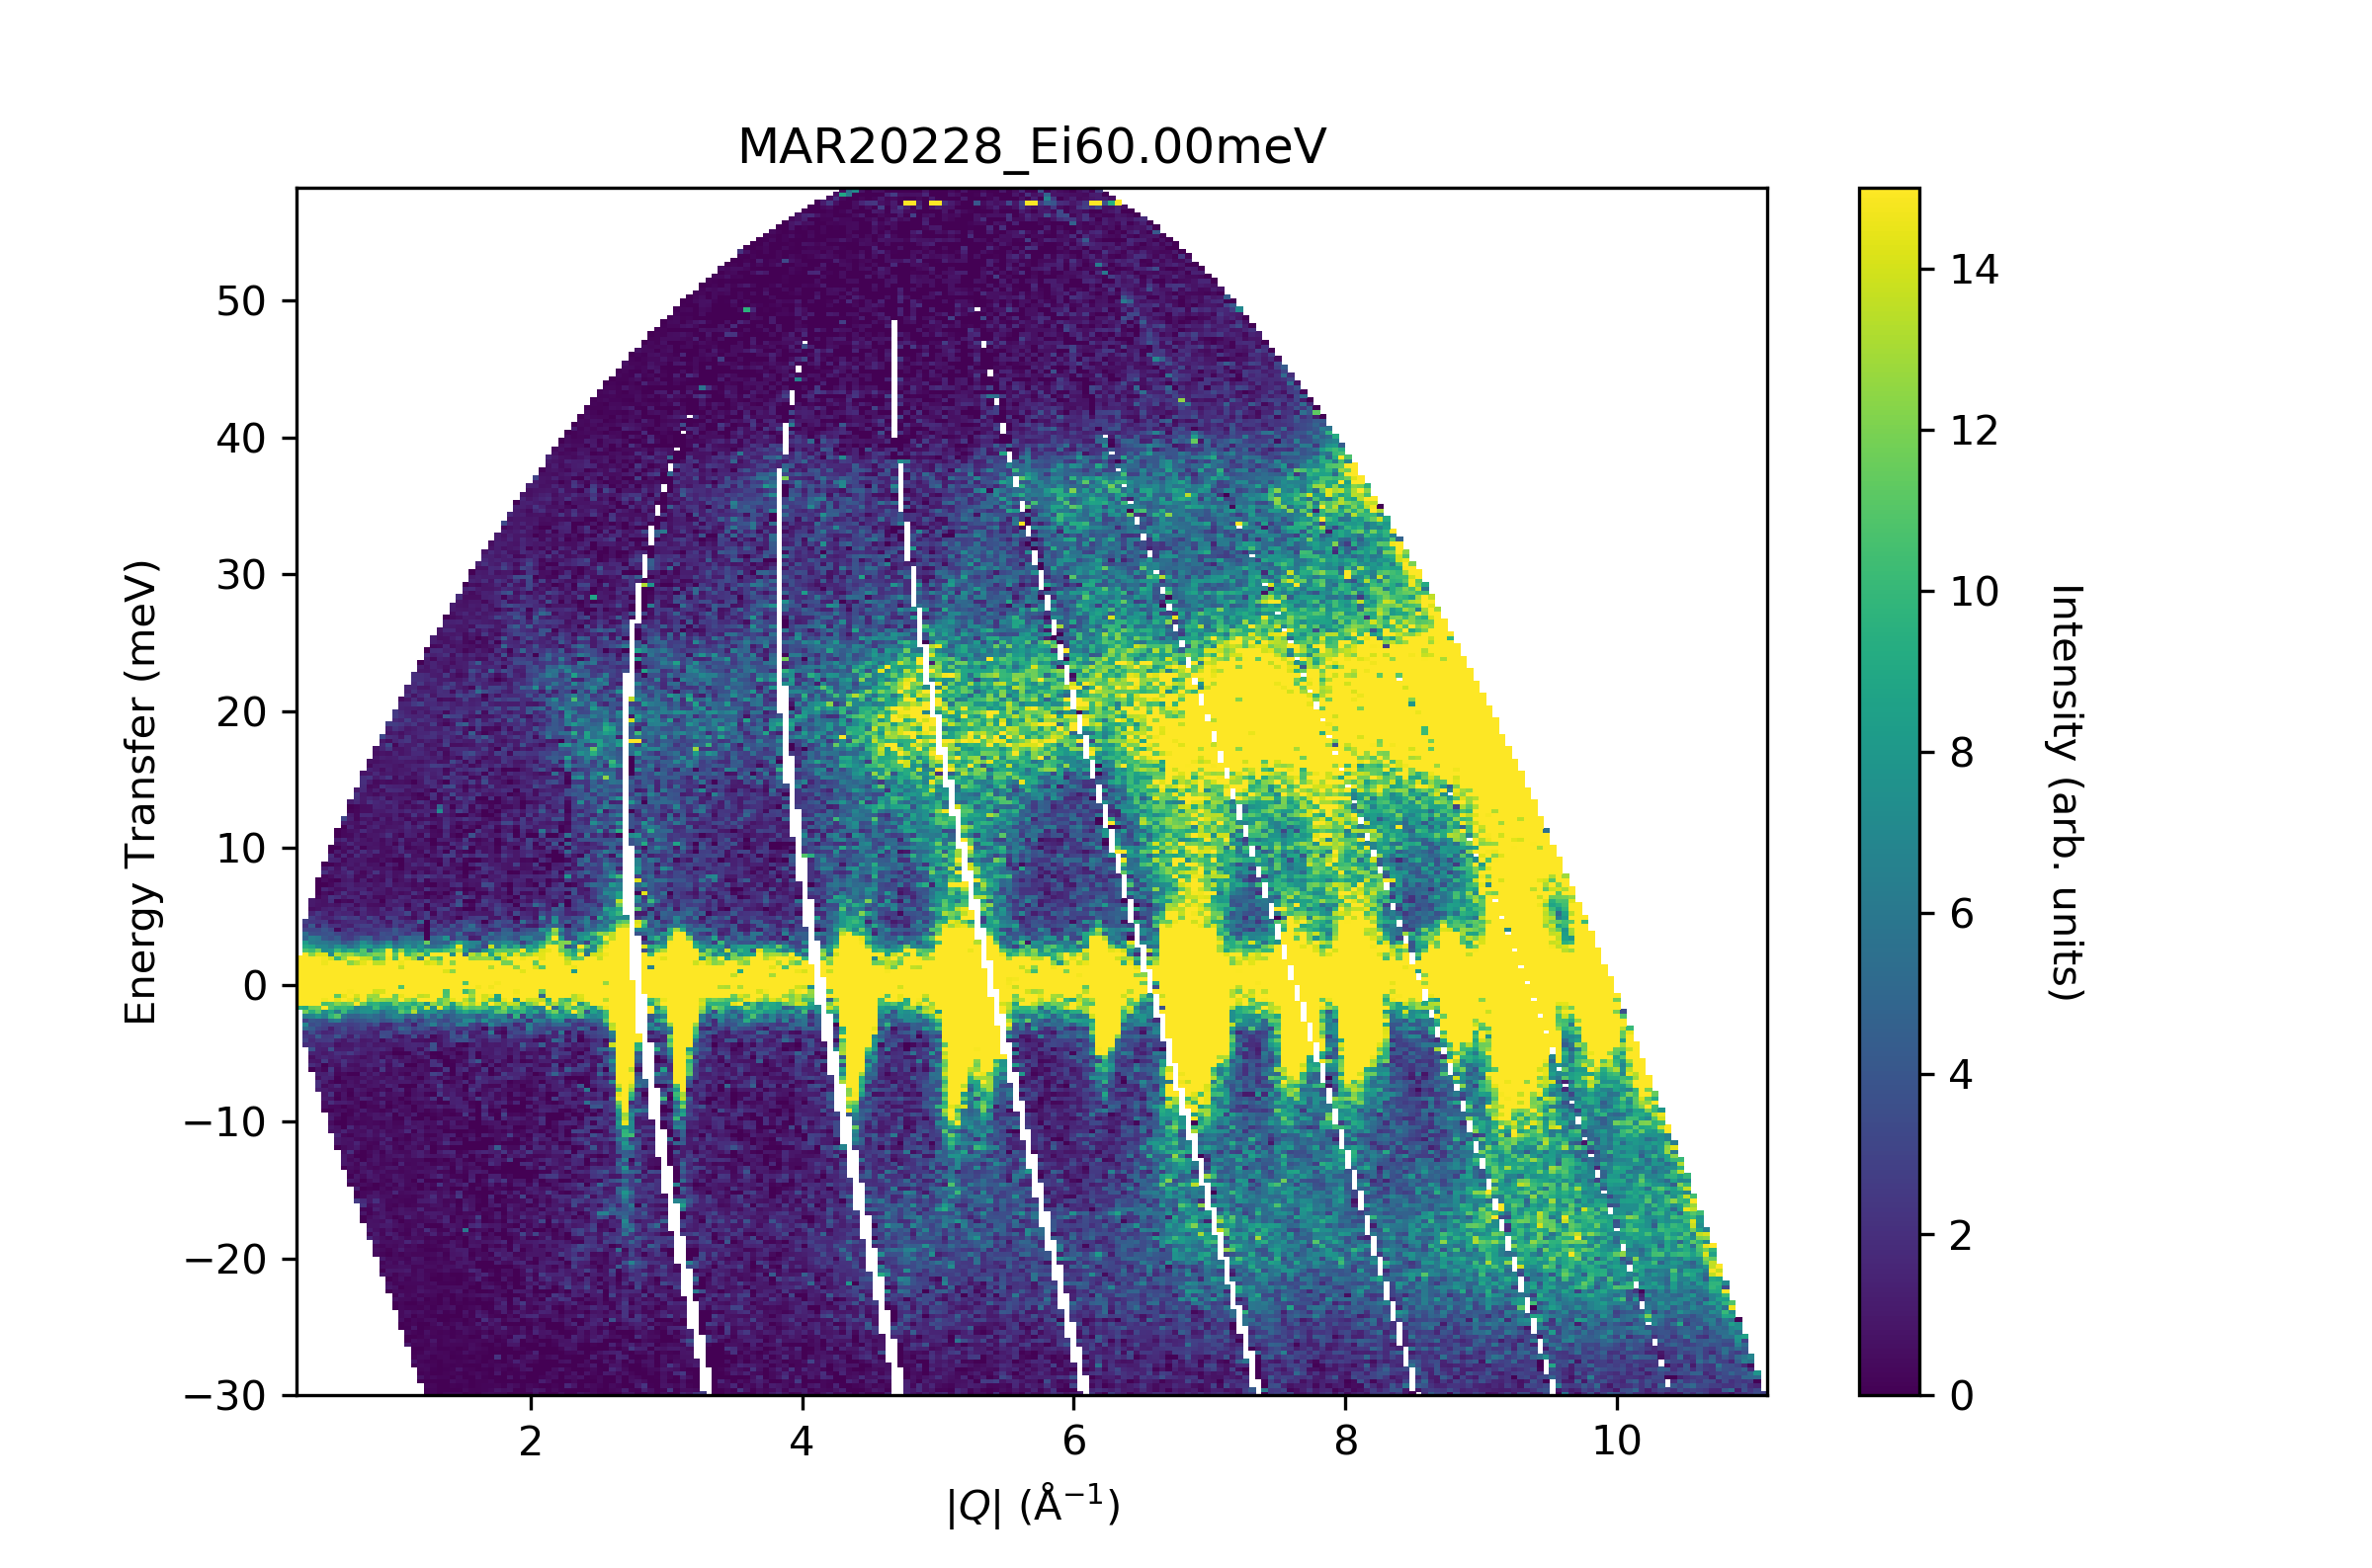

# Silicon

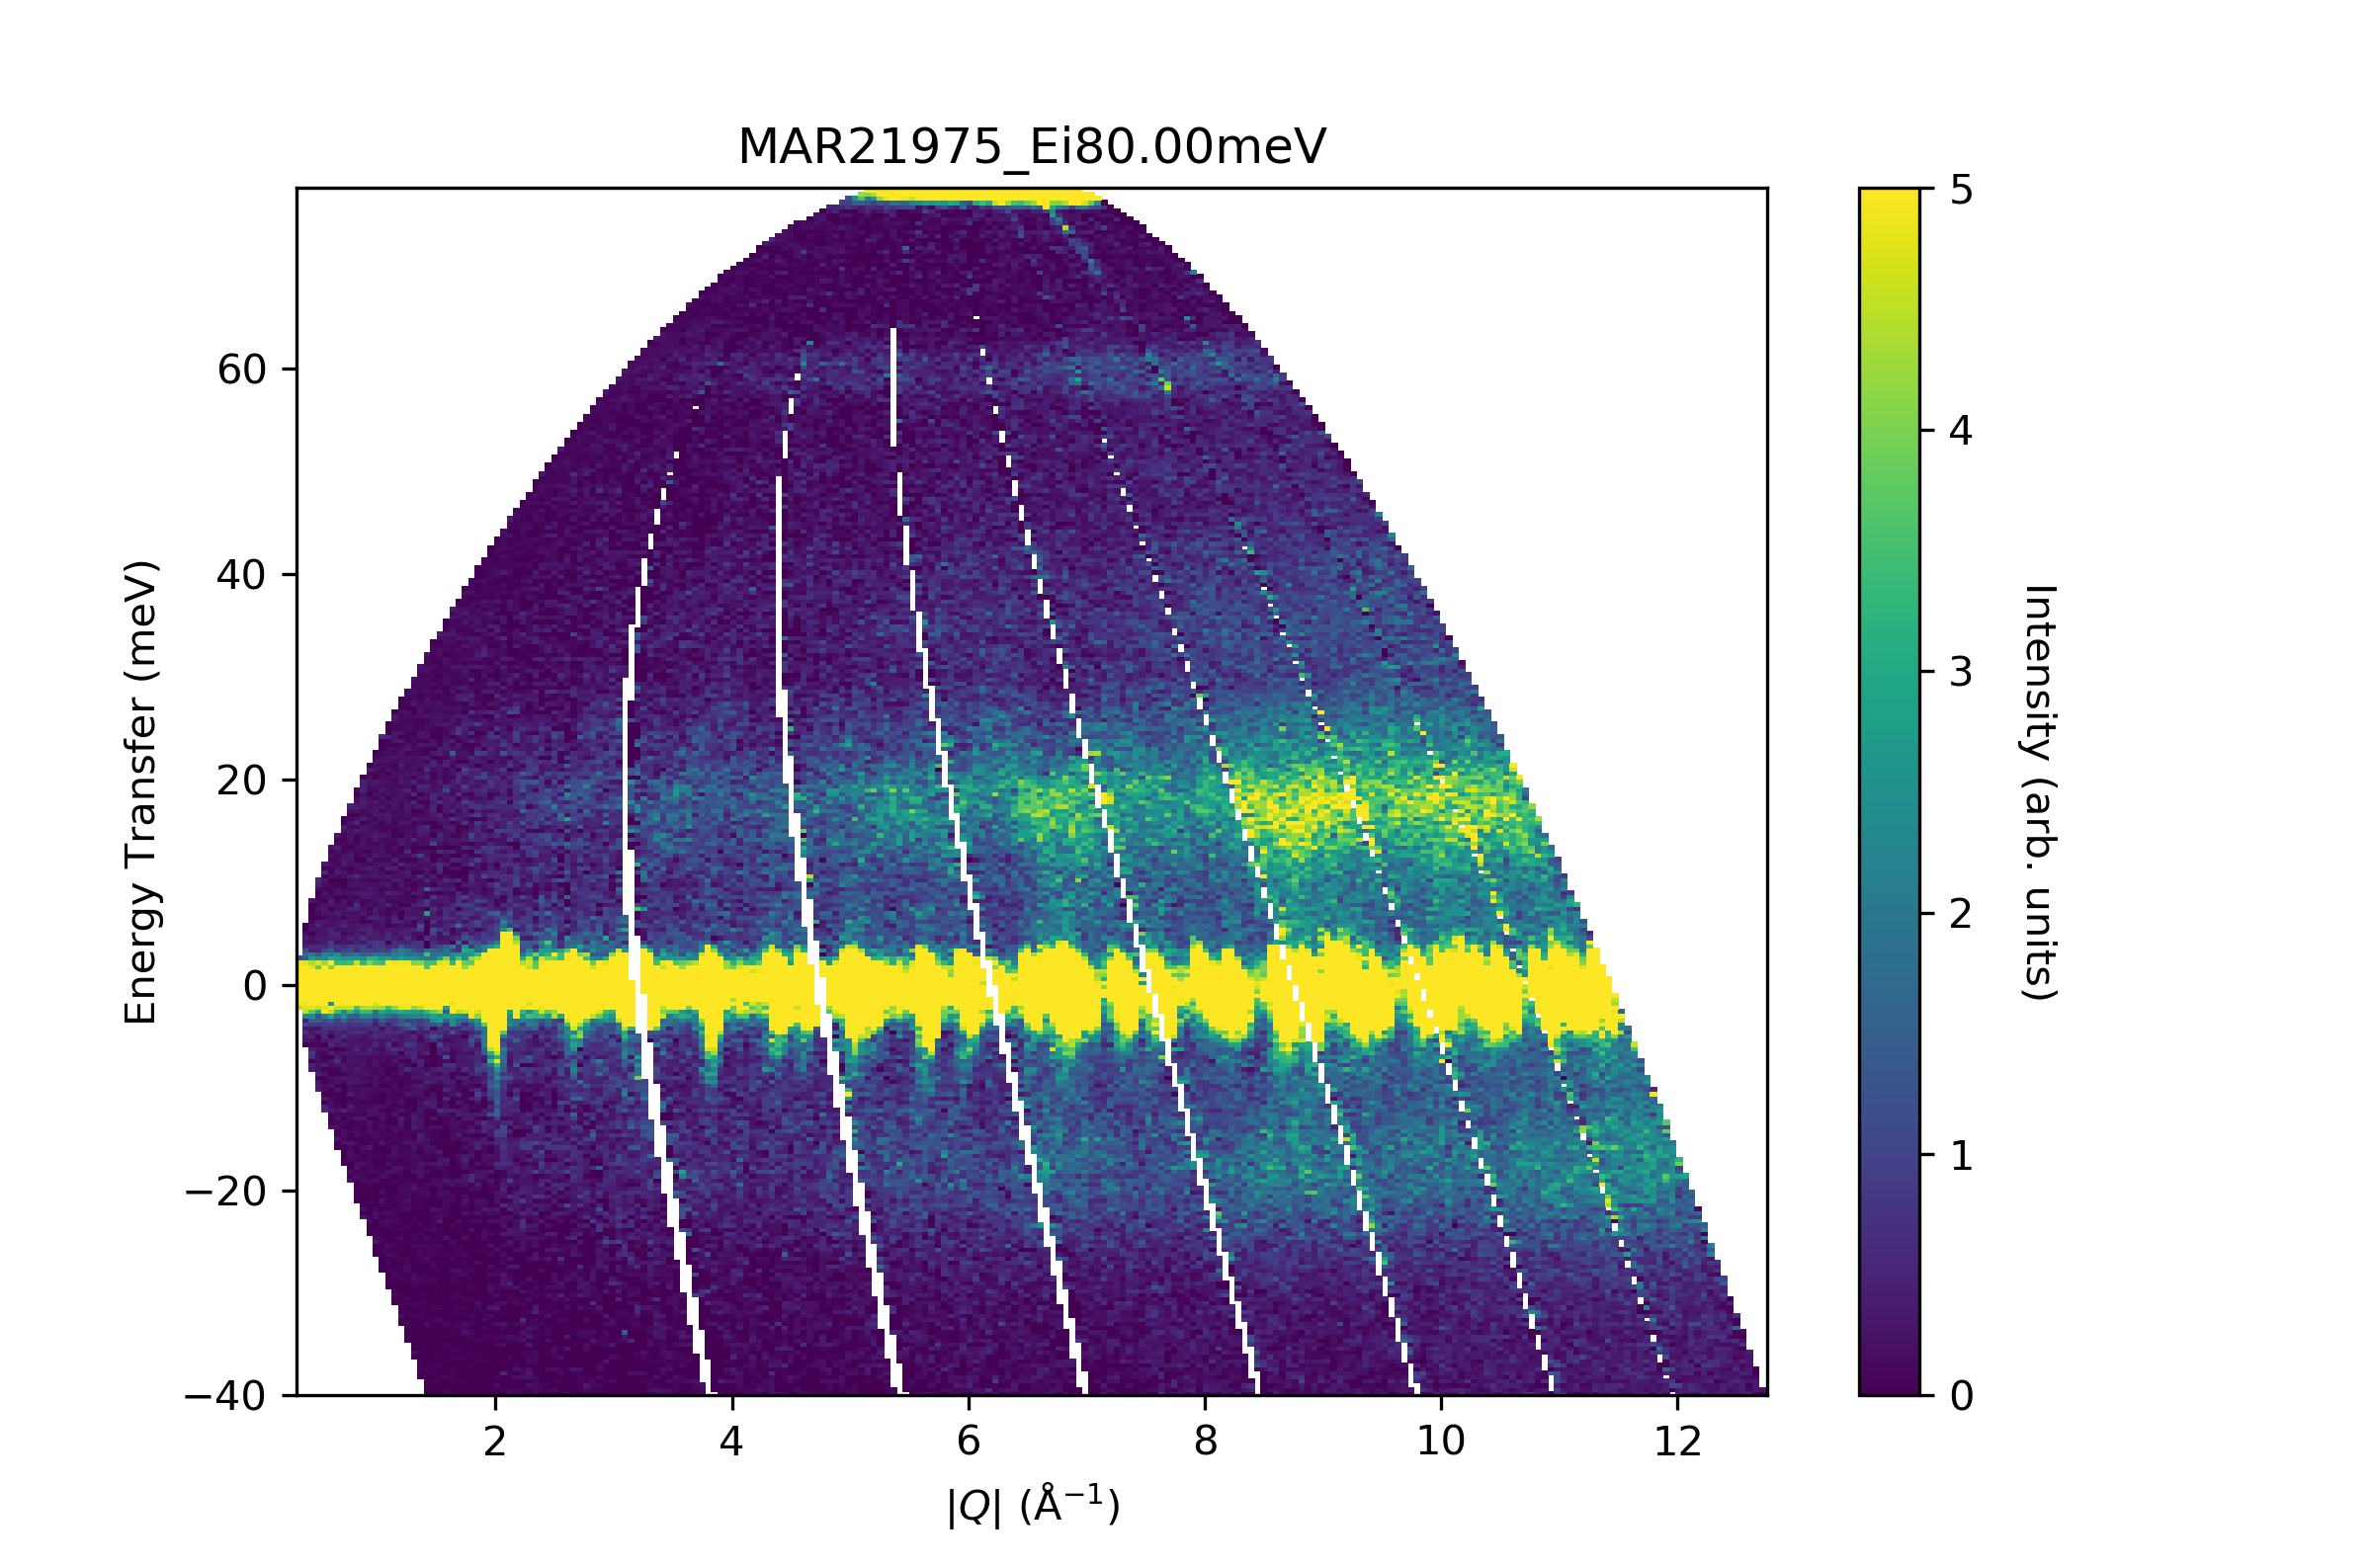